<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initial-redcal-and-abscal-test" data-toc-modified-id="Initial-redcal-and-abscal-test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initial <code>redcal</code> and <code>abscal</code> test</a></span><ul class="toc-item"><li><span><a href="#Setup-and-Metadata" data-toc-modified-id="Setup-and-Metadata-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup and Metadata</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Software" data-toc-modified-id="Software-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Software</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Generate-Uncalibrated-Data" data-toc-modified-id="Generate-Uncalibrated-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate Uncalibrated Data</a></span></li></ul></li><li><span><a href="#Run-Redcal" data-toc-modified-id="Run-Redcal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run Redcal</a></span></li><li><span><a href="#Rephase-to-Evaluate-Solutions" data-toc-modified-id="Rephase-to-Evaluate-Solutions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rephase to Evaluate Solutions</a></span></li></ul></div>

# Initial `redcal` and `abscal` test

Josh Dillon and the HERA Validation Team

## Setup and Metadata

### Abstract

This is a first test of the `hera_cal` scheme as detailed in the [calibration pipeline for IDR](https://github.com/HERA-Team/hera_opm/blob/master/pipelines/h1c/idr2/v2/Analysis_Flowchart.pdf).

It assumes perfect redundancy between nominally redundant baselines, and a set of simulated gains based on `hera_sim`.  The simulation was done with `pyuvsim`, and included 100 randomly placed sources with spectra over the full H1C band (100 - 200 MHz) with Airy beams. Precise parameters recorded below.

Specifically, this tests whether `hera_cal` can, to machine precision, recover the input gains through the steps of redundant calibration (`redcal`) and `abscal` to a perfectly correct sky model.  There is no noise.

### Imports

In [2]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
from IPython.display import Markdown
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import scipy
from hera_cal import io, redcal, abscal, utils, apply_cal
from hera_cal.datacontainer import DataContainer
import hera_cal
import hera_qm
import linsolve
from copy import deepcopy
import hera_sim
import os
from hera_cal.utils import split_pol, split_bl

from importlib import import_module

### Description

In [3]:
print("Last executed: ", datetime.now().isoformat(timespec='minutes'))

Last executed:  2019-07-19T11:06


- **Major Step Description:** Tests of effect of `hera_cal` on final power spectrum
- **Minor Variation Description:** Simple test of `hera_cal` only, for known foregrounds.
- **Pipelines Tested:** `hera_cal`.
- **Criteria**:
  1. Input gains recovered to numerical precision  

### Summary

The results of this validation test, in reference to the outlined criteria, are

1. Input gains recovered to single-numerical-precision.


### Software

In [4]:
for module in ["pyuvdata", "hera_stats", "hera_sim", "hera_qm", "hera_pspec", "linsolve", "uvtools", "numpy", "pyuvsim", "healpy"]:
    try:
        _mdl = import_module(module)
    except ModuleNotFoundError:
        pass
    
    if hasattr(_mdl, 'version'):
        gh = getattr(_mdl.version, 'git_hash', None)
    print("Module {:<11}....\tVersion {:<7}.......\tGit {}".format(module, _mdl.__version__, gh))

Module pyuvdata   ....	Version 1.4.0  .......	Git d1829efacb60da384f64a8f25a280441bfa9d68a
Module hera_stats ....	Version 1.4.0  .......	Git d1829efacb60da384f64a8f25a280441bfa9d68a
Module hera_sim   ....	Version 0.0.1  .......	Git b"b'eea7ebae86797c627237c9d676d3a0581f9df44b'"
Module hera_qm    ....	Version 1.0    .......	Git 393ee1add2bd582b1142f5f5a85ef33664383382
Module hera_pspec ....	Version 1.0    .......	Git 393ee1add2bd582b1142f5f5a85ef33664383382
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git c9fbb3f9fe5697b86f5f768a8593c660f4c3c6df
Module numpy      ....	Version 1.16.4 .......	Git None
Module pyuvsim    ....	Version 1.1.0  .......	Git 
Module healpy     ....	Version 1.12.9 .......	Git None


### Data

The following paths reflect the exact locations of all data used in this test:

In [6]:
path = '/lustre/aoc/projects/hera/Validation/test-2.0.0/'
testfile = 'randsrc_airybeam_Nsrc100_fullband.uvh5'
if not os.path.exists(path+testfile):
    print('File not found.')

Config file used:

```
filing:
  outdir: "./simulation_results/"
  outfile_name: 'randsrc_airybeam_Nsrc100_fullband'
freq:
  Nfreqs: 1024
  channel_width: 97656.25
  start_freq: 100048828.125
sources:
    catalog: 'mock'
    mock_arrangement: 'random'
    Nsrcs: 100
    min_alt: 20.0
    save: True
telescope:
  array_layout: telescope_config/perfect_hex37_14.6m.csv
  telescope_config_name: telescope_config/HERA65_config.yaml
time:
  Ntimes: 5
  integration_time: 10.7374181747
  start_time: 2458110.1852327394
select:
  redundant_threshold: 0.5
```

Antenna layout (`telescope_config/perfect_hex37_14.6m.csv`):
```
Name  Number   BeamID   E          N          U         
ANT0         0        0     0.0000     0.0000     0.0000
ANT1         1        0    14.6000     0.0000     0.0000
ANT2         2        0    29.2000     0.0000     0.0000
ANT3         3        0    43.8000     0.0000     0.0000
ANT4         4        0    58.4000     0.0000     0.0000
ANT5         5        0    73.0000     0.0000     0.0000
ANT6         6        0    87.6000     0.0000     0.0000
ANT7         7        0     7.3000    12.6400     0.0000
ANT8         8        0     7.3000   -12.6400     0.0000
ANT9         9        0    21.9000    12.6400     0.0000
ANT10       10        0    21.9000   -12.6400     0.0000
ANT11       11        0    36.5000    12.6400     0.0000
ANT12       12        0    36.5000   -12.6400     0.0000
ANT13       13        0    51.1000    12.6400     0.0000
ANT14       14        0    51.1000   -12.6400     0.0000
ANT15       15        0    65.7000    12.6400     0.0000
ANT16       16        0    65.7000   -12.6400     0.0000
ANT17       17        0    80.3000    12.6400     0.0000
ANT18       18        0    80.3000   -12.6400     0.0000
ANT19       19        0    14.6000    25.2800     0.0000
ANT20       20        0    14.6000   -25.2800     0.0000
ANT21       21        0    29.2000    25.2800     0.0000
ANT22       22        0    29.2000   -25.2800     0.0000
ANT23       23        0    43.8000    25.2800     0.0000
ANT24       24        0    43.8000   -25.2800     0.0000
ANT25       25        0    58.4000    25.2800     0.0000
ANT26       26        0    58.4000   -25.2800     0.0000
ANT27       27        0    73.0000    25.2800     0.0000
ANT28       28        0    73.0000   -25.2800     0.0000
ANT29       29        0    21.9000    37.9200     0.0000
ANT30       30        0    21.9000   -37.9200     0.0000
ANT31       31        0    36.5000    37.9200     0.0000
ANT32       32        0    36.5000   -37.9200     0.0000
ANT33       33        0    51.1000    37.9200     0.0000
ANT34       34        0    51.1000   -37.9200     0.0000
ANT35       35        0    65.7000    37.9200     0.0000
ANT36       36        0    65.7000   -37.9200     0.0000
```

Telescope config (`telescope_config/HERA65_config.yaml`):
```
beam_paths:
  0: 'airy'
diameter: 14.6
telescope_location: (-30.72152777777791, 21.428305555555557, 1073.0000000093132)
telescope_name: HERA
```

## Generate Uncalibrated Data

In [7]:
hd = io.HERAData(path+testfile)
data, flags, nsamples = hd.read()

In [8]:
print(hd.history.replace("\n","").replace(". ","\n"))

Simulated with pyuvsim version: 0.2.1
 Git origin: https://github.com/RadioAstronomySoftwareGroup/pyuvsim.git
 Git hash: 74ebf0357c757d7a327f79a1ed6db6f98c328695
 Git branch: freq_def
 Git description: v0.2.0-152-g74ebf03-dirty
Sources from source list: mock_rseed2794007488_array_location(-30.721527777777922, 21.428305555555557, 1073.000000008227)_arrangementrandom_Nsrcs100_time2458110.18523
Based on config files: obsparam_airybeam_randsrc_perfecthex.yaml, telescope_config/HERA65_config.yaml,telescope_config/perfect_hex37_14.6m.csv Npus = 110
 Read/written withpyuvdata version: 1.3.6
 Git origin: https://github.com/HERA-Team/pyuvdata.git
 Git hash: e611e26d572e06b16f86a73981123a2eb70a9249
 Git branch: master
 Git description: v1.3-333-ge611e26-dirty
 Read/written with pyuvdata version: 1.3.6
 Git origin: https://github.com/HERA-Team/pyuvdata.git
 Git hash: c1ef8f781367ef4aed08c0c22e0ebbe74d17ec2e
 Git branch: master
 Git description: v1.3-347-gc1ef8f7-dirty.Inflated from redundant base

In [9]:
np.random.seed(21)
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())

# generate gains with a realistic bandpass and delays between -20 and 20 ns
true_gains = hera_sim.sigchain.gen_gains(hd.freqs/1e9, ants, dly_rng=(-20, 20))

# add random phase offsets to each antenna's gain
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in true_gains.keys()}

# uncalibratate data and save
true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
              for ant, g in true_gains.items()}
apply_cal.calibrate_in_place(data, true_gains, gain_convention='multiply')
hd.update(data=data)
hd.write_uvh5(path+'uncalibrated_' + testfile, clobber=True)

File exists; clobbering


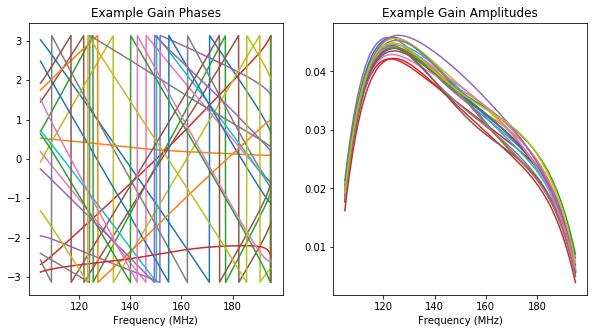

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
for ant in ants[::4]:
    ax[0].plot(hd.freqs[50:-50]/1e6, np.angle(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[0].set_title('Example Gain Phases')
    ax[0].set_xlabel('Frequency (MHz)')
    ax[1].plot(hd.freqs[50:-50]/1e6, np.abs(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[1].set_title('Example Gain Amplitudes')
    ax[1].set_xlabel('Frequency (MHz)')

**Figure 1** | The phase (left) and amplitude (right) of simulated gains.

# Run Redcal

This flags the top and bottom 50 channels. `solar_horizon=90` ensures that no integrations are flagged because the sun is up.

In [11]:
%%time
redcal.redcal_run(path+'uncalibrated_' + testfile, 
                  flag_nchan_high=50, flag_nchan_low=50,
                  solar_horizon=90, clobber=True, verbose=True);


Now running redundant calibration without antennas [] ...
Now calibrating ['xx'] polarization(s)...
    Now calibrating times 2458110.185232736 through 2458110.185729839 ...
Now calibrating ['yy'] polarization(s)...
    Now calibrating times 2458110.185232736 through 2458110.185729839 ...

Now saving firstcal gains to /lustre/aoc/projects/hera/Validation/test-2.0.0/uncalibrated_randsrc_airybeam_Nsrc100_fullband.first.calfits
Now saving omnical gains to /lustre/aoc/projects/hera/Validation/test-2.0.0/uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni.calfits
Now saving omnical visibilities to /lustre/aoc/projects/hera/Validation/test-2.0.0/uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni_vis.uvh5
File exists; clobbering
CPU times: user 3min 1s, sys: 1.11 s, total: 3min 2s
Wall time: 3min 2s


{'g_firstcal': {(0,
   'Jxx'): array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
        dtype=complex64),
  (0, 'Jyy'): array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
        dtype=complex64),
  (1, 'Jxx'): array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
         [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j

In [12]:
%%time
abscal.post_redcal_abscal_run(path+'uncalibrated_' + testfile,
                              path+'uncalibrated_' + testfile.replace('.uvh5', '.omni.calfits'),
                              [path+testfile], clobber=True, verbose=True);



Now calibrating xx-polarization...

    Now calibrating times 2458110.185232736 through 2458110.185729839...


Mean of empty slice


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the dft algorithm


invalid value encountered in true_divide


...configuring global_phase_slope_logcal for the linfit algorithm


invalid value encountered in true_divide


...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.014944657603379126
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.1868913104246167e-08
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.1414892903003597
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.9732680501210577e-08


invalid value encountered in true_divide
invalid value encountered in true_divide




Now calibrating yy-polarization...

    Now calibrating times 2458110.185232736 through 2458110.185729839...


Mean of empty slice


...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the dft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.018274882860985466
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.2585790789018314e-08
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.4625065218007455
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 2.0121639743466004e-08
CPU times: use

# Rephase to Evaluate Solutions

Pick a standard reference antenna (in this case 0) and rephase all gains so that that antennas has 0 phase. This removes the final (albeit unphysical) degree of freedom, allowing the abscal gains and true, simulated gains to be directly compared. 

We expect our answers to match to within single precision, which is how they are stored on disk.

In [13]:
hc = io.HERACal(path+'uncalibrated_randsrc_airybeam_Nsrc100_fullband.abs.calfits')
g, gf, q, tq = hc.read()

In [14]:
refant = {'Jxx': (0, 'Jxx'), 'Jyy': (0, 'Jyy')}
agr = {ant: g[ant] * np.abs(g[refant[ant[1]]]) / g[refant[ant[1]]] 
            for ant in g.keys()}
tgr = {ant: true_gains[ant] * np.abs(true_gains[refant[ant[1]]]) / true_gains[refant[ant[1]]] 
            for ant in true_gains.keys()}

In [15]:
for pol in ['Jxx', 'Jyy']:
    gain_errors = [agr[ant][~gf[ant]] - tgr[ant][~gf[ant]] for ant in tgr if ant[1] == pol]
    assert np.mean(np.abs(gain_errors)) < 1e-6
    print('{} Mean Abs Gain Error: '.format(pol), np.mean(np.abs(gain_errors)))

Jxx Mean Abs Gain Error:  5.8859952281494516e-09
Jyy Mean Abs Gain Error:  5.059116343445388e-09
